In [218]:
import pinocchio
import numpy as np
import time 
import pymanopt 
from pymanopt import manifolds, optimizers, tools, core
from pymanopt.core.problem  import Problem
from pymanopt.tools.diagnostics import *
from utils import *
import networkx as nx
from scipy import optimize
from scipy.optimize import Bounds
import matplotlib.pyplot as plt

import tqdm

from scipy.sparse import csr_array

LOWER = "lower_limit"
UPPER = "upper_limit"
BOUNDED = "bounded"
BELOW = "below"
ABOVE = "above"
TYPE = "type"
OBSTACLE = "obstacle"
ROBOT = "robot"
END_EFFECTOR = "end_effector"
RADIUS = "radius"
DIST = "weight"
POS = "pos"
BASE = "base"
ROOT = None
ANCHOR = "anchor"
BASE_GRAPH = "base_graph"
UNDEFINED = None


deg2rad = np.pi/180.
rad2deg = 180./np.pi

scale = 1

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def forwardKinematics(model,data,q,scale=1):
    pinocchio.forwardKinematics(model,data,q)
    for idx, oMi in enumerate(data.oMi):
        oMi.translation = scale*oMi.translation



In [1367]:
def create_base_graph(model,data,axis_length):

    trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))

    q_init = pinocchio.neutral(model)
    pinocchio.forwardKinematics(model,data,q_init)
    
    robot_name = model.names[1]
    ROOT = robot_name

    base = nx.empty_graph()

    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            cur_pos, aux_cur_pos = (
                oMi.translation*scale,
                pinocchio.SE3.act(pinocchio.SE3(oMi.rotation,oMi.translation*scale),trans_z).translation,
            )
            #print(name,cur_pos,aux_cur_pos)
            dist = np.linalg.norm(cur_pos - aux_cur_pos)

            # Add nodes for joint and edge between them
            base.add_nodes_from(
                [(cur, {POS: cur_pos}), (aux_cur, {POS: aux_cur_pos})]
            )
            base.add_edge(
                cur, aux_cur, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False}
            )

            # If there exists a preceeding joint, connect it to new
            if idx != 0:
                pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')
                for u in [pred, aux_pred]:
                    for v in [cur, aux_cur]:
                        dist = np.linalg.norm(
                            base.nodes[u][POS] - base.nodes[v][POS]
                        )
                        base.add_edge(
                            u,
                            v,
                            **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: False},
                        )
        elif idx == 1:
            #print(name,oMi.translation)
            base = nx.DiGraph(
                [
                    (robot_name, "x"),
                    (robot_name, "y"),
                    (robot_name, robot_name+'_tilde'),
                    ("x", "y"),
                    ("y", robot_name+'_tilde'),
                    (robot_name+'_tilde' ,"x"),
                ]
            )
            base.add_nodes_from(
                [
                    ("x", {POS: np.array([axis_length, 0, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    ("y", {POS: np.array([0, -axis_length, 0]) + oMi.translation*scale, TYPE: [BASE]}),
                    (robot_name, {POS: oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                    (robot_name+'_tilde', {POS: np.array([0, 0, axis_length]) + oMi.translation*scale, TYPE: [ROBOT, BASE]}),
                ]
            )
            for u, v in base.edges():
                base[u][v][DIST] = np.linalg.norm(base.nodes[u][POS] - base.nodes[v][POS])
                base[u][v][LOWER] = base[u][v][DIST]
                base[u][v][UPPER] = base[u][v][DIST]
                base[u][v][ANCHOR] = True
                base[u][v][BOUNDED] = []

    # Set node type to robot
    nx.set_node_attributes(base, [ROBOT], TYPE)
    base.nodes[ROOT][TYPE] = [ROBOT, BASE]
    base.nodes[ROOT + '_tilde'][TYPE] = [ROBOT, BASE]

    return base

In [1434]:

def norm(x):
    return x/max(np.linalg.norm(x),10**-9)

def goal_graph(model, data, G, axis_length, position, direction = None, anchor = True):
    
    end_effector = [model.names[-1]]
    if direction is not None:
        end_effector.append(model.names[-1]+'_tilde')

    list_nodes_base = ['x','y',model.names[1],model.names[1]+'_tilde']

    for i, cur_end_effector in enumerate(end_effector):
        pos_end = position

        if direction is not None and i == 1:
            pos_end = pos_end + direction*axis_length
        
        G.nodes[cur_end_effector][POS] = pos_end

        for cur_base in list_nodes_base:
            
            if not((i == 1) and (len(end_effector)==1)):
                dist = np.linalg.norm(pos_end-G.nodes[cur_base][POS])

                G.add_edge(
                            cur_base, cur_end_effector, **{DIST: dist, LOWER: dist, UPPER: dist, BOUNDED: [], ANCHOR: anchor}
                        )
    
    if True:#anchor:

        list_edges_anchor = []
        list_other_edges = []
        new_edge_order  = []
        A_anchor = []

        for key ,anch_ in nx.get_edge_attributes(G,ANCHOR).items():

            if anch_:
                list_edges_anchor.append(key)
                A_anchor.append(norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
                #print(key,' : ',norm(G.nodes[key[1]][POS]- G.nodes[key[0]][POS]))
            else:
                list_other_edges.append(key)
        new_edge_order = list_edges_anchor.copy() #.extend(list_other_edges)

        for e in list_other_edges:
            new_edge_order.append(e)

        A_anchor = np.array(A_anchor).transpose()
        
    else:

        list_edges_anchor = []
        list_other_edges = [e for e in G.edges()]

        new_edge_order = list_other_edges
        A_anchor = []

    n = len(list_other_edges)
    n_anchor = len(list_edges_anchor)

    weight = nx.get_edge_attributes(G, DIST)
    D = np.diag([weight[i] for i in new_edge_order])

    C = incidence_matrix_(G,oriented=True, edgelist=new_edge_order).toarray()
    C = np.array(C)

    Y_init = np.zeros((3,n))

    for i, e in enumerate(list_other_edges):
        i = i 
        p1 = G.nodes[e[0]][POS]
        p2 = G.nodes[e[1]][POS]
        Y_init[:,i] = (p2-p1)/max(np.linalg.norm(p2-p1),10**-9)

    Y_init = [A_anchor,Y_init]
    return G, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init

In [1640]:
alpha_elu = 10**-8
elu = lambda x: alpha_elu*(np.exp(x/alpha_elu*(x<0))-1)*(x<0) +  x*(x>=0)
d_elu = lambda x: np.exp(x/alpha_elu*(x<0))*(x<0) + (x>=0)
dd_elu = lambda x: 1/alpha_elu*np.exp(x/alpha_elu*(x<0))*(x<0)

def simple_IK(d ,C , C_joints_limit ,D ,D_joints ,n_below, n_above, Anchor_ ,M ,max_iter,ind=None ,W=None ,Y_init=None ,
                use_rand=False, min_grad_norm = 10**-10,verbosity = 2):
    if  W is None:
        W = np.eye(D.shape[0])
    if len(Anchor_)>0:
        #print('ANCHOR')
        n_anchor = Anchor_.shape[1]
        Anchor = np.zeros((d,n_anchor))
        Anchor[:3,:] = Anchor_


        M = manifolds.Product([manifolds.ConstantFactory(Anchor),
                manifolds.Oblique(d,D.shape[1]-Anchor.shape[1])])
    else:
         M = manifolds.Oblique(d,D.shape[1])

    Q2 = -D@(W@C.transpose()@np.linalg.pinv(C@W@C.transpose()))@C@W@D
    Q1 = D@W@D

    Q_below = C_joints_limit[:n_below,:D.shape[0]]
    Q_above = C_joints_limit[n_below:,:D.shape[0]]

    D_below = D_joints[:n_below]**2
    D_above = D_joints[n_below:]**2
    #print(Q_below.shape)

    if len(Anchor_)>0:
        Y = M.random_point()
        ind = [0]
        ind.extend([y.shape[1] for y in Y])
        ind = np.array(ind)
        ind = np.cumsum(ind)
        n = len(Y)


        @pymanopt.function.numpy(M)
        def cost(*Y):
            Y = np.concatenate(Y,axis=1)

            constr_below = - (np.linalg.norm(Q_below@Y.transpose(),axis=1)**2 - D_below)
            constr_above = (np.linalg.norm(Q_above@Y.transpose(),axis=1)**2 - D_above)

            #constr = lambda_cons*(np.linalg.norm(np.maximum(constr_below, 0))**2 + np.linalg.norm(np.maximum(constr_above, 0))**2) 
            #constr = lambda_cons*(np.sum(np.maximum(constr_below, 0)) + np.sum(np.maximum(constr_above, 0))) 
            constr = lambda_cons*(np.sum(elu(constr_below)) + np.sum(np.maximum(constr_above, 0))) 

            #print(constr,constr_below)
            return np.trace(Q1 + Q2@Y.transpose()@Y) + constr
        QQ_below = np.array([q[:,np.newaxis]@q[:,np.newaxis].transpose() for q in Q_below])
        zip_below = zip(D_below,Q_below,QQ_below)
        zip_above = zip(D_above,Q_above)
        @pymanopt.function.numpy(M)
        def euclidean_gradient(*Y):
            Y = np.concatenate(Y,axis=1)
            grad = 2*Q2@Y.transpose()

            #grad_below = - sum([4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@Y.transpose() for d,q,qq in zip_below])
            #grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@Y.transpose() for d,q,qq in zip_below])
            grad_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*d_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

            if len(D_above)>0:
                grad_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose() for d,q in zip_above])
            else:
                grad_above = 0
            #print('grad',np.linalg.norm(grad_above))
            grad = grad + lambda_cons*(grad_below + grad_above)
            return [grad.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
                                
        @pymanopt.function.numpy(M)
        def euclidean_hessian(*U):
            
            Y = np.concatenate(U[:n],axis=1)
            U = np.concatenate(U[n:],axis=1)

            #hess_below = sum([-4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@U.transpose() + 8*(qq@Y.transpose())@Y@(qq)@U.transpose()*(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q,qq in zip(D_below,Q_below,QQ_below)])
            
            #hess_below = sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*qq@U.transpose() for d,q,qq in zip(D_below,Q_below,QQ_below)])
            hess_below = - sum([2*((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0))*dd_elu(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2)*qq@Y.transpose() for d,q,qq in zip_below])

            if len(D_above)>0:
                hess_above = sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@Y@(q[:,np.newaxis]@q[:,np.newaxis].transpose())@U.transpose()*(-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q in zip(D_above,Q_above)])
            else:
                hess_above = 0

            #hess_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*((q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@U)@(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose()) for d,q in zip(D_above,Q_above)])

            hess =  lambda_cons*(hess_above + hess_below)
            
            hess = (2*Q2)@U.transpose() + hess

            return [hess.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
    else:
        @pymanopt.function.numpy(M)
        def cost(Y):
            #Y = np.concatenate(Y,axis=1)

            constr_below = - (np.linalg.norm(Q_below@Y.transpose(),axis=1)**2 - D_below)
            constr_above = (np.linalg.norm(Q_above@Y.transpose(),axis=1)**2 - D_above)

            constr = lambda_cons*(np.linalg.norm(np.maximum(constr_below, 0))**2 + np.linalg.norm(np.maximum(constr_above, 0))**2) 
            print(constr,constr_below)
            return np.trace(Q1 + Q2@Y.transpose()@Y) + constr
        QQ_below = np.array([q[:,np.newaxis]@q[:,np.newaxis].transpose() for q in Q_below])
        zip_below = zip(D_below,Q_below,QQ_below)
        zip_above = zip(D_above,Q_above)
        @pymanopt.function.numpy(M)
        def euclidean_gradient(Y):
            #Y = np.concatenate(Y,axis=1)
            grad = 2*Q2@Y.transpose()
            f = np.array((-D_below + np.linalg.norm(Q_below@Y.transpose(),'fro')**2 >0))[:,np.newaxis]
            grad_below = - sum([4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@Y.transpose() for d,q,qq in zip_below])
            #grad_below = - 4*(np.maximum(-D_below + np.linalg.norm(Q_below@Y.transpose(),'fro')**2,0)*Q_below.transpose())@(f*Q_below)@Y.transpose()
            if len(D_above)>0:
                grad_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose() for d,q in zip_above])
            else:
                grad_above = 0
            #print('grad',np.linalg.norm(grad_above))
            grad = grad + lambda_cons*(grad_below + grad_above)
            return grad.transpose()#[grad.transpose()[:,start:end] for start, end in zip(ind[:-1],ind[1:])]
                                
        @pymanopt.function.numpy(M)
        def euclidean_hessian(Y,U):
            
            #Y = np.concatenate(U[:n],axis=1)
            #U = np.concatenate(U[n:],axis=1)

            hess_below = sum([-4*max((d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*qq@U.transpose() + 8*(qq@Y.transpose())@Y@(qq)@U.transpose()*(d-np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q,qq in zip(D_below,Q_below,QQ_below)])

            if len(D_above)>0:
                hess_above = sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@Y@(q[:,np.newaxis]@q[:,np.newaxis].transpose())@U.transpose()*(-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2>0) for d,q in zip(D_above,Q_above)])
            else:
                hess_above = 0

            #hess_above= sum([4*max((-d+np.linalg.norm(q[:,np.newaxis].transpose()@Y.transpose(),'fro')**2,0))*q[:,np.newaxis]@q[:,np.newaxis].transpose()@U.transpose() + 8*((q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose())@U)@(q[:,np.newaxis]@q[:,np.newaxis].transpose()@Y.transpose()) for d,q in zip(D_above,Q_above)])

            hess =  lambda_cons*(hess_above + hess_below)
            hess = ((2*Q2)@U.transpose()).transpose() + hess.transpose()

            return hess


    problem = Problem(manifold=M, 
                        cost=cost,
                        euclidean_gradient=euclidean_gradient, 
                        euclidean_hessian=euclidean_hessian,
                        )
    #check_gradient(problem)
    optimizer = optimizers.TrustRegions(max_iterations=max_iter,use_rand=use_rand,min_gradient_norm=min_grad_norm,verbosity=verbosity)

    if  Y_init is None:
        Y_init_ = M.random_point()
    elif n_anchor > 1:
        if Y_init[1].shape[0] == d:
            Y_init_ = Y_init
        elif Y_init[1].shape[0] < d:
            Y_init_ = np.zeros((d,Y[1].shape[1]))
            Y_init_[:Y_init[1].shape[0],:] = Y_init[1]
            Y_init_ = [Anchor, Y_init_]
        else:
            if len(Y_init) == 2:
                U,S,V = np.linalg.svd(Y_init[1],full_matrices=False)
            else:
                U,S,V = np.linalg.svd(Y_init,full_matrices=False)
            Y_init_ = [Anchor, U[:d,:d]@np.diag(S)[:d,:]@V/np.maximum(np.linalg.norm(U[:d,:d]@np.diag(S)[:d,:]@V,axis=0),10**-9)]
    

    Y_star = optimizer.run(problem,initial_point=Y_init_).point

    return Y_star


In [1644]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 10**0
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)
#Y_D4 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=400,ind=None,W=W,Y_init=Y_init_,use_rand=False)
Y_D3 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=500,ind=None,W=W,Y_init=None,use_rand=True)

[ 0.30524904 -1.04416347 -0.46968819] [ 0.90092128  0.33228176 -0.27915888]
Optimizing...
                                            f: +2.129898e+01   |grad|: 4.078598e+00
acc TR+   k:     1     num_inner:     0     f: +1.375754e+01   |grad|: 4.235753e+00   negative curvature
acc       k:     2     num_inner:     0     f: +4.820517e+00   |grad|: 2.441089e+00   exceeded trust region
acc       k:     3     num_inner:     1     f: +1.682731e+00   |grad|: 1.134675e+00   exceeded trust region
acc       k:     4     num_inner:     4     f: +1.086634e+00   |grad|: 1.074947e+00   exceeded trust region
acc       k:     5     num_inner:     5     f: +9.097988e-01   |grad|: 8.973862e-01   exceeded trust region
acc TR-   k:     6     num_inner:     8     f: +8.437296e-01   |grad|: 9.181798e-01   exceeded trust region
acc       k:     7     num_inner:     2     f: +5.815231e-01   |grad|: 1.218315e-01   reached target residual-kappa (linear)
REJ TR-   k:     8     num_inner:     7     f: +5.815231

In [1558]:
def direction_to_position(Y,C,D,data):
    X = np.linalg.pinv(C@C.transpose())@C@D@Y.transpose()

    X = X - X[0,:] + data.oMi[1].translation*scale

    
    v = X[1,:] - X[0,:]
    R = rotation_matrix_from_vectors(v/np.linalg.norm(v),e1/np.linalg.norm(e1))
    X = (X - X[0,:])@R.transpose() + X[0,:]

    v = X[2,:] - X[0,:]
    R = rotation_matrix_from_vectors(v/np.linalg.norm(v),-e2/np.linalg.norm(e2))
    X = (X - X[0,:])@R.transpose() + X[0,:]
    flip = 1

    if X[3,2]<axis_length:
        flip = -1
    v = X[2,:] - X[0,:]
    R = np.diag((1,1,flip))
    X = (X - X[0,:])@R.transpose() + X[0,:]

    return X

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [1559]:
def skew(x):
    """
    Creates a skew symmetric matrix from vector x
    """
    X = np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])
    return X


def joint_variables(model,data, G, T_final, axis_length):
    """
    Finds the set of decision variables corresponding to the
    graph realization G.

    :param G: networkx.DiGraph with known vertex positions
    :param T_final: poses of end-effectors in case two final frames aligned along z
    :returns: Dictionary of joint angles
    :rtype: Dict[str, float]
    """
    tol = 1e-10
    
    T = {}
    T[model.names[1]] = data.oMi[1] 

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}

    trans_z = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    
    # resolve scale
    x_hat = G.nodes["x"][POS] - G.nodes[model.names[1]][POS]
    y_hat = G.nodes["y"][POS] - G.nodes[model.names[1]][POS]
    z_hat = G.nodes[model.names[1]+'_tilde'][POS] - G.nodes[model.names[1]][POS]

    # resolve rotation and translation
    x = norm(x_hat)
    y = norm(y_hat)
    z = norm(z_hat)
    R = np.vstack((x, -y, z)).T
    B = pinocchio.SE3(R, np.zeros((3,))) #G.nodes[ROOT][POS])

    omega_z = skew(np.array([0,0,1]))

    theta = {}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 1:
            cur, aux_cur = (name, name+'_tilde')
            pred, aux_pred = (model.names[idx-1], model.names[idx-1]+'_tilde')

            T_prev = T[pred]
            
            T_prev_0 = T_zero[pred] # previous p xf at 0
            T_0 = T_zero[cur] # cur p xf at 0
            T_0_q = pinocchio.SE3.act(T_zero[cur],trans_z) # cur q xf at 0
            T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0) # relative xf
            ps_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0).translation # relative xf
            qs_0 = pinocchio.SE3.act(pinocchio.SE3.inverse(T_prev_0),T_0_q).translation # rel q xf

            # predicted p and q expressed in previous frame
            p = pinocchio.SE3.act(pinocchio.SE3.inverse(B),G.nodes[cur][POS])
            qnorm = G.nodes[cur][POS] + (
                G.nodes[aux_cur][POS] - G.nodes[cur][POS]
            ) / np.linalg.norm(G.nodes[aux_cur][POS] - G.nodes[cur][POS])
            q = pinocchio.SE3.act(pinocchio.SE3.inverse(B),qnorm)
            #print(T_prev)
            ps = pinocchio.SE3.inverse(T_prev).rotation.dot(p - T_prev.translation)  # in prev. joint frame
            qs = pinocchio.SE3.inverse(T_prev).rotation.dot(q - T_prev.translation)  # in prev. joint frame

            theta[cur] = np.arctan2(-qs_0.dot(omega_z).dot(qs), qs_0.dot(omega_z.dot(omega_z.T)).dot(qs))
            rot_axis_z = pinocchio.SE3(Rot_z(theta[cur]),np.zeros((3,)))
            T[cur] = pinocchio.SE3.act(pinocchio.SE3.act(T_prev,rot_axis_z),T_rel)

    # if the rotation axis of final joint is aligned with ee frame z axis,
    # get angle from EE pose if available
    #if ((T_final is not None) and (la.norm(cross(T_rel.trans, np.asarray([0, 0, 1]))) < tol)):
     #   T_th = (T[cur]).inv().dot(T_final[ee]).as_matrix()
     #   theta[ee] = wraptopi(theta[ee] +  arctan2(T_th[1, 0], T_th[0, 0]))

    return theta

In [1616]:
def root_angle_limits(G,model,data,axis_length):
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)
    limited_joints = [] 
    i = 2
    T1 = data.oMi[1]
    base_names = ["x", "y"]
    names = [model.names[i],model.names[i]+'_tilde']
    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))

    for base_node in base_names:
        for node in names:
            T0 = pinocchio.SE3.Identity()
            T0.translation = G.nodes[base_node][POS]

            if node == model.names[i]:
                T2 = data.oMi[i]
            else:
                T2 = pinocchio.SE3.act(data.oMi[i],T_axis)

            N = T1.rotation[0:3, 2]
            C = T1.translation + (N.dot(T2.translation - T1.translation)) * N
            r = np.linalg.norm(T2.translation - C)
            P = T0.translation
            d_max, d_min = max_min_distance_revolute(r, P, C, N)
            d = np.linalg.norm(T2.translation - T0.translation)

            if d_max == d_min:
                limit = False
            elif d == d_max:
                limit = BELOW
            elif d == d_min:
                limit = ABOVE
            else:
                limit = None

            if limit:
                T_rel = pinocchio.SE3.act(pinocchio.SE3.inverse(T1),data.oMi[i])
                if node != model.names[i]:
                    T_rel = pinocchio.SE3.act(T_rel,T_axis)

                d_limit = np.linalg.norm(
                    pinocchio.SE3.act(pinocchio.SE3.act(T1,pinocchio.SE3(Rot_z(upper_limits[0]),np.zeros((3,)))),T_rel).translation
                    - T0.translation
                )

                q0 = np.zeros((upper_limits.shape[0]))
                q0[0] = upper_limits[0]
                
                pinocchio.framesForwardKinematics(model,data,q0)

                if '_tilde' not in node:
                    d_limit = np.linalg.norm(data.oMi[1].translation-T0.translation)
                if '_tilde' in node:
                    d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[1],T_axis).translation-T0.translation)

                if limit == ABOVE:
                    d_max = d_limit
                else:
                    d_min = d_limit
                limited_joints += [model.names[i]]  # joint at p0 is limited
            
            G.add_edge(base_node, node)
            if d_max == d_min:
                G[base_node][node][DIST] = d_max
            G[base_node][node][BOUNDED] = [limit]
            G[base_node][node][UPPER] = d_max
            G[base_node][node][LOWER] = d_min

            

    return G

In [1688]:
def set_limits(G,model,data,axis_length):
    """
    Sets known bounds on the distances between joints.
    This is induced by link length and joint limits.
    """
    T_axis = pinocchio.SE3(np.eye(3),np.array([0,0,axis_length]))
    upper_limits = np.minimum(-model.lowerPositionLimit,model.upperPositionLimit)

    limited_joints = []  # joint limits that can be enforced

    pinocchio.forwardKinematics(model,data,pinocchio.neutral(model))
    T_zero = {name: oMi for name, oMi in zip(model.names, data.oMi)}
    
    for idx, (name, oMi) in enumerate(zip(model.names, data.oMi)):
        if idx > 2:
            cur, prev = name, model.names[idx - 2]
            names = [
                (prev, name),
                (prev,name+'_tilde'),
                (prev+'_tilde', name),
                (prev+'_tilde', name+'_tilde'),
            ]


            for ids in names:
                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                
                pinocchio.framesForwardKinematics(model,data,q0)
                if '_tilde' not in ids[0] and '_tilde' not in ids[1]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = pinocchio.SE3.Identity()
                elif '_tilde' in ids[1] and '_tilde' not in ids[0]:
                    TT1 = pinocchio.SE3.Identity()
                    TT2 = T_axis
                elif '_tilde' not in ids[1] and '_tilde' in ids[0]:

                    TT1 = T_axis
                    TT2 = pinocchio.SE3.Identity()
                else:
                    TT1 = T_axis
                    TT2 = T_axis

                q0 = np.zeros((upper_limits.shape[0]))
                q0[idx-2] = upper_limits[idx-2]
                pinocchio.framesForwardKinematics(model,data,q0)
                d_limit = np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation)
                
                list_dist = []
                
                for theta in np.linspace(0,upper_limits[idx-2],101):
                    q0 = np.zeros((upper_limits.shape[0]))
                    q0[idx-2] = theta
                    pinocchio.framesForwardKinematics(model,data,q0)
                    list_dist.append(np.linalg.norm(pinocchio.SE3.act(data.oMi[idx-2],TT1).translation - pinocchio.SE3.act(data.oMi[idx],TT2).translation))
                
                list_dist = np.array(list_dist)
                diff_dist = list_dist[:-1] - list_dist[1:]
                
                d_max = max(list_dist)
                d_min = min(list_dist)
                if np.max(np.abs(diff_dist))<10**-7:
                    limit = False
                    d_max = d_limit
                    d_min = d_limit
                elif sum((diff_dist > 0)) == 100:
                    limit = BELOW
                elif sum((diff_dist < 0)) == 100:
                    limit = ABOVE
                else:
                    limit=False
                    print('#############################################')


                limited_joints += [cur]

                G.add_edge(ids[0], ids[1])
                if d_max == d_min:
                    G[ids[0]][ids[1]][DIST] = d_max
                G[ids[0]][ids[1]][BOUNDED] = [limit]
                G[ids[0]][ids[1]][UPPER] = d_max
                G[ids[0]][ids[1]][LOWER] = d_min

                if limit:
                    break
    return G, limited_joints

In [1562]:
def constraints_graph(model, data, G, D, new_edge_order, axis_length):
    D_tilde = {name: [val, ind] for ind, (name, val) in enumerate(zip(new_edge_order,D))}

    list_edges_below = []
    list_edges_above = []

    D_below = []
    D_above = []

    path = {}

    for n1 in G.nodes():
        for n2 in G.nodes():

            path[(n1,n2)] = []

            if n1 != n2 and ((n1,n2) not in new_edge_order):
                for p in nx.all_simple_edge_paths(G, n1, n2, 2):
                    if len(p)>1:
                        path[(n1,n2)].append(p)

    G = root_angle_limits(G,model,data,axis_length)
    G, lim_joints = set_limits(G,model,data,axis_length)

    for edge, val in nx.get_edge_attributes(G,BOUNDED).items():

        if BELOW in val:
            D_below.append(G[edge[0]][edge[1]][LOWER])
            list_edges_below.append(edge)
        if ABOVE in val:
            D_above.append(G[edge[0]][edge[1]][UPPER])
            list_edges_above.append(edge)

    list_edges_joints_limit = list_edges_below.copy()
    list_edges_joints_limit.extend(list_edges_above)
    
    D_joints_limit = D_below.copy()
    D_joints_limit.extend(D_above)
    
    C_joints_limit = np.zeros((len(list_edges_joints_limit),len(list_edges_joints_limit)+len(new_edge_order)))
    
    for idx, e in enumerate(list_edges_joints_limit):
        p = path[e][0]
        
        C_joints_limit[idx,D_tilde[p[0]][1]] = D_tilde[p[0]][0]
        C_joints_limit[idx,D_tilde[p[1]][1]] = D_tilde[p[1]][0]

        C_joints_limit[idx,len(new_edge_order)+idx] = -1
    
    return G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above


NameError: name 'axis' is not defined

In [1716]:
axis_length = 0.3*scale
urdf_filename="GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'

model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()

G = create_base_graph(model,data,axis_length)

q0 = np.array([30,-120,170,-40,90,0,0])*np.pi/180
#q0 = np.array([0,0,0,0,0,0,0])*np.pi/180
q0 = pinocchio.randomConfiguration(model)
pinocchio.framesForwardKinematics(model,data,q0)
position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
direction = data.oMi[-1].rotation@np.array([0,0,1])

print(position, direction)
ROOT = model.names[1]

G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G, axis_length, 
                                                                                                 position, direction = direction, anchor = True)


G1, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below, list_edges_above = constraints_graph(model, data, G1, np.diag(D), new_edge_order, axis_length)
print(A_anchor.shape)
q = np.array([90,0,0,0,0,0])*np.pi/180
pinocchio.framesForwardKinematics(model,data,q)
for i,oMi in enumerate(data.oMi):
    print(i,oMi)

[-0.51499168  0.04618109  0.64463235] [-0.22830384  0.31881468 -0.91991008]
#############################################
#############################################
#############################################
#############################################
#############################################
#############################################
(3, 14)
0   R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0

1   R =
6.12323e-17          -1           0
          1 6.12323e-17           0
          0           0           1
  p =      0      0 0.1273

2   R =
6.12323e-17          -1           0
          1 6.12323e-17           0
          0           0           1
  p =   -0.220941 1.35287e-17      0.1273

3   R =
6.12323e-17          -1           0
          1 6.12323e-17           0
          0           0           1
  p =  -0.049041 3.0029e-18     0.7393

4   R =
2.99833e-28          -1 6.12323e-17
4.89664e-12 6.12323e-17           1
         -1           0 4.89664e-12
  p =  -0.049041 3.0029e-1

In [1702]:
W = np.diag(1./np.diag(D)**2)
M=None
lambda_cons = 0*10**-1
n_below = len(list_edges_below)
n_above = len(list_edges_above)
print(position,direction)
Y_D4 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=400,ind=None,W=W,Y_init=Y_init_,use_rand=False)
Y_D3 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=3000,ind=None,W=W,Y_init=Y_D4,use_rand=True)
print(len(Y_D3))

[ 0.42067835 -0.27582899  1.22542206] [-0.09777676 -0.01085874  0.99514913]
Optimizing...
                                            f: +1.883581e+00   |grad|: 1.857152e+00
acc TR+   k:     1     num_inner:     0     f: +3.577945e-01   |grad|: 8.021626e-01   exceeded trust region
REJ TR-   k:     2     num_inner:     4     f: +3.577945e-01   |grad|: 8.021626e-01   exceeded trust region
acc TR+   k:     3     num_inner:     2     f: +8.008848e-02   |grad|: 2.532689e-01   exceeded trust region
acc       k:     4     num_inner:     7     f: +3.831359e-02   |grad|: 2.859620e-01   exceeded trust region
acc       k:     5     num_inner:     3     f: +1.823432e-03   |grad|: 2.730772e-02   reached target residual-kappa (linear)
REJ TR-   k:     6     num_inner:    29     f: +1.823432e-03   |grad|: 2.730772e-02   exceeded trust region
acc       k:     7     num_inner:    25     f: +8.062788e-04   |grad|: 1.521791e-02   exceeded trust region
acc       k:     8     num_inner:    32     f: +2.780

In [1703]:
Y_star = Y_D3[:2]
e1 = np.array([1,0,0])
e2 = np.array([0,1,0])
e3 = np.array([0,0,1])

if len(Y_star) == 2:
    X = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
else:
    X = direction_to_position(Y_star,C,D,data)

print(X)
print(np.linalg.norm(X[-2,:]-position))
print(np.linalg.norm((X[-1,:]-X[-2,:])/axis_length-direction))
print(position)

for idx,node in enumerate(G1.nodes()):
    G1.nodes[node][POS] = X[idx,:]

theta = joint_variables(model,data, G1, data.oMi[-1], axis_length)
theta = np.array([theta_ for key, theta_ in theta.items()])
pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
print(np.linalg.norm(position-data.oMi[-1].translation))
print(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))
print(model.upperPositionLimit*rad2deg)
print(q0*rad2deg)
(theta*rad2deg).tolist()


[[ 0.00000000e+00  0.00000000e+00  1.27300000e-01]
 [ 3.00002766e-01 -5.04819973e-06  1.27300000e-01]
 [-7.36079757e-22 -3.00002282e-01  1.27300000e-01]
 [ 3.18561455e-05 -3.34941671e-05  4.27345665e-01]
 [ 2.05914521e-01 -8.01952716e-02  1.27442887e-01]
 [ 1.97954150e-01 -9.84153319e-02  4.27084021e-01]
 [ 3.38594593e-01 -2.02972859e-01  7.37139073e-01]
 [ 3.13924059e-01 -2.65398437e-01  1.02975526e+00]
 [ 2.87258227e-01 -3.41288557e-01  1.28992929e+00]
 [ 5.81836349e-01 -3.97194665e-01  1.30352462e+00]
 [ 3.07109247e-01 -2.56794862e-01  1.21452900e+00]
 [ 6.02429881e-01 -3.01759960e-01  1.24288784e+00]
 [ 4.20762954e-01 -2.75939436e-01  1.22538708e+00]
 [ 3.91515772e-01 -2.79240250e-01  1.52393930e+00]]
0.0001434566992696564
0.00032129826844079723
[ 0.42067835 -0.27582899  1.22542206]
0.34292819136404223
1.113945348696696
[360. 360. 180. 360. 360. 360.]
[ 226.95406062 -143.10317294 -167.51379165  311.40740396  144.23836493
  -25.80059952]


[-128.13827133604613,
 -65.78096354963135,
 -148.4982104473885,
 123.58951875964343,
 -102.27710838216534]

In [1619]:
count_success = 0
success_range = 0

fail_range = []
err_pos = []
err_or = []
fail = []
scale = 1
lambda_cons = 10*0

axis_length = 0.2*scale
urdf_filename="GraphIK/graphik/robots/urdfs/ur10_mod.urdf"
#"GraphIK/graphik/robots/urdfs/kuka_iiwr.urdf"
# 'GraphIK/graphik/robots/urdfs/panda_arm.urdf'

model    = pinocchio.buildModelFromUrdf(urdf_filename)
data     = model.createData()


G = create_base_graph(model,data,axis_length)
G, D_joints_limit, list_edges_joints_limit, C_joints_limit, list_edges_below,list_edges_above = constraints_graph(model, data, G, np.diag(D), new_edge_order, axis_length)  

Y_D3 = Y_init_
q = pinocchio.randomConfiguration(model)
q = np.array([0,0,0,90,0,0])*np.pi/180

for i in tqdm.tqdm(range(10**3)):
    #print('NEW OPT')
    q = q + np.random.normal(size=(q.shape[0],))*1.*deg2rad
    q = np.clip(q,model.lowerPositionLimit,model.upperPositionLimit)
    #Y_D3 = Y_init_
    #q = pinocchio.randomConfiguration(model)
    #q = pinocchio.randomConfiguration(model)
    pinocchio.framesForwardKinematics(model,data,q)
    position = data.oMi[-1].translation*scale #np.array([200,0,500])/1000
    direction = data.oMi[-1].rotation@np.array([0,0,1])

    #print(position, direction)

    G1, list_edges_anchor, list_edges_anchor, new_edge_order, n,n_anchor, A_anchor, D,C, Y_init_ = goal_graph(model, data, G.copy(), axis_length, 
                                                                                                 position, direction = direction, anchor = True)
    

    W = np.diag(1./np.diag(D)**2)#np.diag(np.concatenate([np.ones(n_anchor),np.ones(n)]))
    M=None
    
    n_below = len(list_edges_below)
    n_above = len(list_edges_above)
    #Y_D5 = simple_IK(5,C,D,A_anchor,M,max_iter=100,ind=None,W=None,Y_init=None,use_rand=False)

    #print(q*rad2deg,position,direction)
    Y_D4 = simple_IK(4,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_D3,use_rand=False,min_grad_norm=10**-7,verbosity = 0)
    Y_D3 = simple_IK(3,C,C_joints_limit,D,np.array(D_joints_limit),n_below ,n_above ,A_anchor,M,max_iter=1000,ind=None,W=W,Y_init=Y_D4,use_rand=True,min_grad_norm=10**-8,verbosity = 0)
        
    Y_star = Y_D3[:2]

    if len(Y_star) == 2:
        #print(ANCHOR)
        X = direction_to_position(np.concatenate([Y_star[0],Y_star[1]],axis=1),C,D,data)
    else:
        X = direction_to_position(Y_star,C,D,data)
    
        
    for idx,node in enumerate(G1.nodes()):
        G1 .nodes[node][POS] = X[idx,:]

    theta = joint_variables(model,data, G1, data.oMi[-1], axis_length)
    theta = np.array([theta_ for key, theta_ in theta.items()])
    pinocchio.forwardKinematics(model,data,np.concatenate([theta,np.zeros((1,))]))
    err_pos.append(np.linalg.norm(position-data.oMi[-1].translation))
    #print(err_pos[-1])
    if direction is not None:
        err_or.append(np.linalg.norm(direction-data.oMi[-1].rotation@np.array([0,0,1])))

    if not (False in (theta>model.lowerPositionLimit[:6]).tolist() or False in (theta<model.upperPositionLimit[:6]).tolist()) :
        success_range = success_range + 1
        fail.append(False)
    else:
        fail.append(True)
        #print(q*rad2deg,theta*rad2deg,position,direction)
        #print('''
        
        
        
        
        
        
        
        
        
        
        
        #''')
        fail_range.append([theta,position,direction,q,X])


#############################################
#############################################
#############################################
#############################################
#############################################
#############################################


KeyError: ('y', 'shoulder_pan_joint_tilde')

In [1610]:
print(max(err_pos),max(err_pos),success_range)
succ = 0
for o,p,f in zip(err_or,err_pos, fail):
    if np.abs(o)<10**-3 and np.abs(p)<10**-3 and not f:
        succ = succ +1 
print(succ)
print(theta*rad2deg)
model.upperPositionLimit*rad2deg

0.0004122831321498675 0.0004122831321498675 826
826
[ -68.97968897  -77.95451166 -158.16051996   91.07155008   66.42661861
  103.37995805]


array([170., 120., 170., 120., 170., 120., 175.])

[102.08594417   0.87103832 -92.26821476  79.54107095 172.67402832
   6.11028064] [ 1.33166190e+00 -3.45081467e-02  7.41223316e+00  7.95570695e+01
  2.11499855e+00 -6.05932703e+00 -5.77491971e-02]
[-0.46887804 -0.07239616  0.85841604] [-0.98492717 -0.15542284  0.07590921]
##############
[ 99.36259658   0.7288422  -91.87441145  81.52102368 174.34445489
   7.40659121] [ 1.19886054e+00 -1.81788332e-02  5.42461034e+00  8.15427455e+01
  9.19598169e-01 -7.36162824e+00  3.39676637e+00]
[-0.47358723 -0.05514571  0.84022817] [-0.99291041 -0.11736553  0.0188217 ]
##############
[103.23740568   0.31899683 -94.20753855  83.83231704 176.57834449
   7.18544718] [ 2.07186795e+00 -1.44320851e-02  6.60171869e+00  8.38493573e+01
 -5.63586160e-01 -7.16485222e+00  4.73077495e+00]
[-0.47334136 -0.07209406  0.82130413] [-0.98858853 -0.14956843 -0.01794458]
##############
[ -28.08985727  -66.54077464 -147.70500469  100.62890601    1.67681137
  120.54076726] [  8.67952404  35.69871787 -45.25095759 100.62391229

array([-170., -120., -170., -120., -170., -120., -175.])

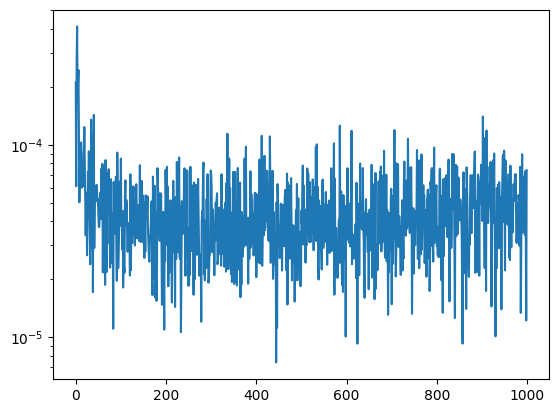

In [1611]:
plt.semilogy(err_pos)
for dd in fail_range:
    print(dd[0]*rad2deg, dd[3]*rad2deg)
    print(dd[1],dd[2])
    print('##############')
model.lowerPositionLimit*rad2deg